In [5]:
import os
os.chdir('..')

In [6]:
pwd

'/mnt/md1/user_victor/automatic_melody_harmonization'

In [23]:
from model.MusicCVAE import MusicCVAE

In [7]:
from tonal import pianoroll2number, joint_prob2pianoroll96
from tonal import tonal_centroid, chord482note, chord962note, note2number
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pickle
from model.MusicCVAE import MusicCVAE
from decode import *
import matplotlib.pyplot as plt
import math

In [15]:

melody = np.load('./data/melody_baseline.npy')
length = np.load('./data/length.npy')


In [16]:

melody_seqs = torch.from_numpy(melody).float()
length = torch.from_numpy(length)

In [18]:
# Load model
device = 'cpu'
print('building model...')
model = MusicCVAE(teacher_forcing = False, 
                  eps_i=0, 
                  device = device,
                  batch_size = 1).to(device)
model.load_state_dict(torch.load('output_models/model_music_cvae_latent_256.pth',map_location='cpu'))
# model.load_state_dict(torch.load('output_models/model_ctdcvae_conv_prenet.pth'))
print(model)
model.eval()

building model...
MusicCVAE(
  (encoder): GRU(96, 1024, num_layers=2, batch_first=True, bidirectional=True)
  (hidden2mean): Linear(in_features=4096, out_features=256, bias=True)
  (hidden2logv): Linear(in_features=4096, out_features=256, bias=True)
  (melody_prenet): GRU(576, 1024, num_layers=2, batch_first=True, bidirectional=True)
  (latent2conductor_input): Linear(in_features=256, out_features=96, bias=True)
  (latent2conductor_hidden): Linear(in_features=256, out_features=1024, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (conductor): GRU(4192, 1024, num_layers=2, batch_first=True)
  (conductor_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Tanh()
  )
  (decoder): GRU(928, 1024, num_layers=2, batch_first=True)
  (outputs2chord): Linear(in_features=1024, out_features=96, bias=True)
)


MusicCVAE(
  (encoder): GRU(96, 1024, num_layers=2, batch_first=True, bidirectional=True)
  (hidden2mean): Linear(in_features=4096, out_features=256, bias=True)
  (hidden2logv): Linear(in_features=4096, out_features=256, bias=True)
  (melody_prenet): GRU(576, 1024, num_layers=2, batch_first=True, bidirectional=True)
  (latent2conductor_input): Linear(in_features=256, out_features=96, bias=True)
  (latent2conductor_hidden): Linear(in_features=256, out_features=1024, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (conductor): GRU(4192, 1024, num_layers=2, batch_first=True)
  (conductor_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Tanh()
  )
  (decoder): GRU(928, 1024, num_layers=2, batch_first=True)
  (outputs2chord): Linear(in_features=1024, out_features=96, bias=True)
)

In [19]:
def top_k_top_p(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
    """
    logits = logits.clone()
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


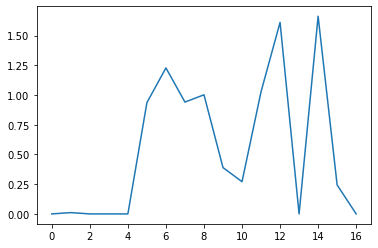

In [58]:
# Sampling
# torch.manual_seed(0)
# batch = melody.shape[0]
batch = melody.shape[0]
latent_size = 256

top_p_chord_onehot_seqs = []
top_p_surprisingness_seqs = []

for song_index in tqdm(range(1)):
#     song_index = 8
    sample_melody = melody_seqs[song_index].unsqueeze(0).to(device)
    sample_length = length[song_index].unsqueeze(0).to(device)
    
    chord_seqs = []
    
    # model inference
    latent = torch.randn(1,latent_size).to(device)
    melody_token = model.melody_embedding(sample_melody,sample_length)
    output, softmax = model.decode(latent, melody_token, None, sample_melody)

    logits = torch.max(softmax[0],-1)
    max_idx = logits.indices
#     print('softmax',logits[0])
#     print('softmax index ',logits[1])

    ## Softmax Normalized
    normed_softmax = softmax.clone()
#     for i in range(sample_length):
#         normed_softmax[:,i,:] = normed_softmax[:,i,:] / normed_softmax[:,i,max_idx[i]].item()

    # Top p Sample
    top_p_pred = torch.zeros((272,96))
    top_p_sample_idx = []
    surprisingness_seq = []
    for i in range(272):
        normed_softmax[:,i,:] = normed_softmax[:,i,:] / normed_softmax[:,i,max_idx[i]].item()
        
        top_p_sample = top_k_top_p(softmax[0][i], top_p=0.03)
        top_p_probs = F.softmax(top_p_sample, dim=-1)
        idx = torch.multinomial(top_p_probs, 1).item()
        top_p_pred[i,idx] = 1
        top_p_sample_idx.append(idx)
        
        surprisingness_seq.append(-torch.log(normed_softmax[0][i][top_p_sample_idx[i]]).item()) 
    
#     print('top_p_sample_idx',top_p_sample_idx)

    # Calculate surprisingness
#     surprisingness_seq = []
#     for i in range(sample_length):
#         surprisingness_seq.append(-torch.log(normed_softmax[0][i][top_p_sample_idx[i]]).item()) 
    
    top_p_chord_onehot_seqs.append(top_p_pred.numpy())
    top_p_surprisingness_seqs.append(surprisingness_seq)
    
    # Plot surprisingness 
    fig, ax = plt.subplots()
    ax.plot(surprisingness_seq[:sample_length])

top_p_chord_onehot_seqs = np.asarray(top_p_chord_onehot_seqs)
top_p_surprisingness_seqs = np.asarray(top_p_surprisingness_seqs)
top_p_surprisingness_seqs = np.expand_dims(top_p_surprisingness_seqs,axis=-1)

np.save('./data/top_p_chord_onehot_seqs.npy',top_p_chord_onehot_seqs)
np.save('./data/top_p_surprisingness_seqs.npy',top_p_surprisingness_seqs)

In [53]:
max_idx

tensor([ 0,  0, 56,  0,  0,  0,  0, 73,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 56,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 73,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 56,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 56,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 56,  0,  0,  0,  0,  0,  0,  0, 79,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 

In [55]:
########## Random sampling ###########
# Proceed chord decode
print('proceed chord decode...')
joint_prob = top_p_pred.cpu().detach().numpy()

# Append argmax index to get pianoroll array
accompany_pianoroll = argmax2pianoroll(joint_prob)

# augment chord into frame base
BEAT_RESOLUTION = 24
BEAT_PER_CHORD = 2

accompany_pianoroll_framewise, sample_chord_groundtruth_framewise = sequence2frame(accompany_pianoroll, sample_chord_groundtruth_idx)

# length into frame base
sample_length_framewise = sample_length * BEAT_RESOLUTION * BEAT_PER_CHORD

# write pianoroll
result_dir = 'results/smusic_cvae_top_p_test'
filename = str(song_index)
write_one_pianoroll(result_dir, filename, sample_melody_framewise, accompany_pianoroll_framewise, sample_chord_groundtruth_framewise, sample_length_framewise, sample_tempo, sample_downbeat)


proceed chord decode...
accompany_pianoroll shape (272, 96, 128)


NameError: name 'sample_chord_groundtruth_idx' is not defined